# Import the data

In [5]:
import pandas as pd 
import numpy as np

df_raw_train = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_train.csv")
df_raw_test = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_test.csv")

In [6]:
df_raw_train = df_raw_train
df_raw_test = df_raw_test

# Visualize few trajectories

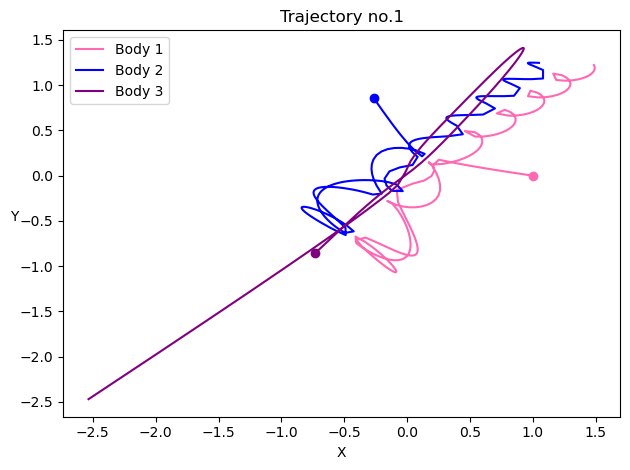

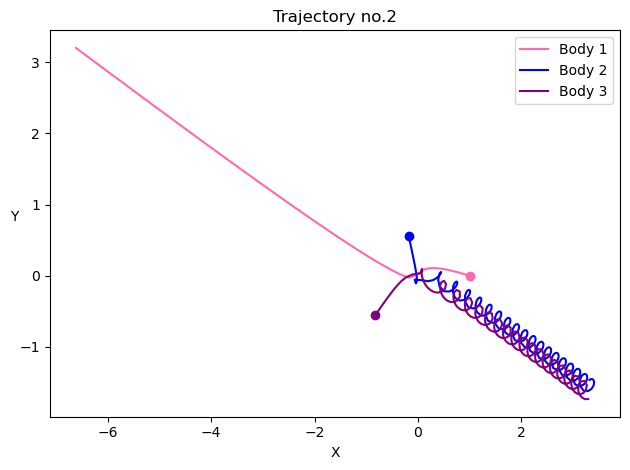

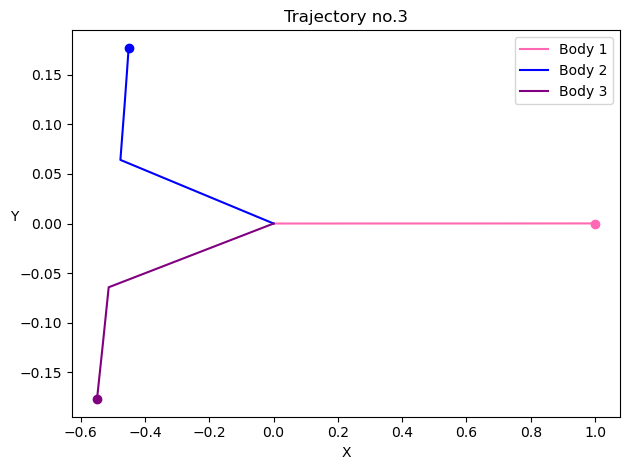

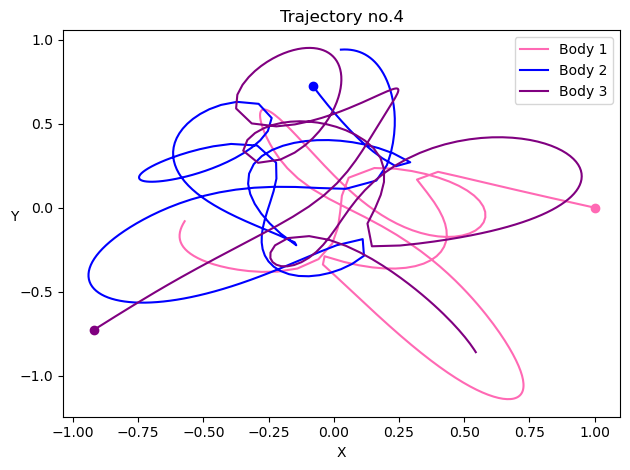

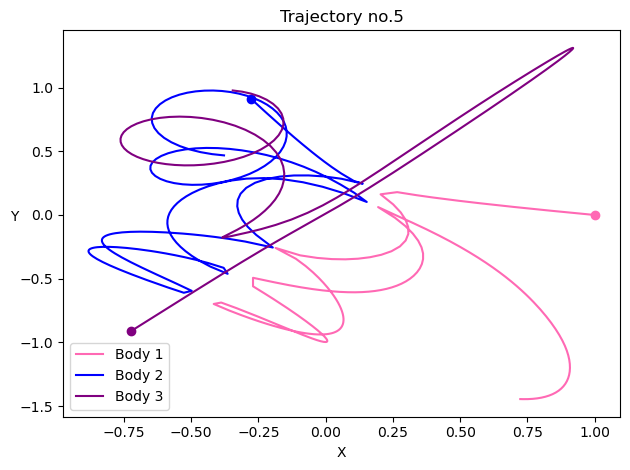

In [7]:
import matplotlib.pyplot as plt

start = 0
end = 257

for i in range(5):
    trajectory = df_raw_train[start:end]
    x1, y1, x2, y2, x3, y3 = trajectory.x_1, trajectory.y_1, trajectory.x_2, trajectory.y_2, trajectory.x_3, trajectory.y_3
    plt.plot(x1, y1, color="hotpink", label = "Body 1")
    plt.plot(x2, y2, color="blue", label = "Body 2")
    plt.plot(x3, y3, color="purple", label = "Body 3")
    plt.scatter(x1[start], y1[start], color="hotpink")
    plt.scatter(x2[start], y2[start], color="blue")
    plt.scatter(x3[start], y3[start], color="purple")
    plt.xlabel("X")
    plt.ylabel("Y", rotation=0)
    plt.title("Trajectory no." + str(i+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    start += 257
    end += 257


# Prepare the dataset

In [8]:
df_raw_train["group"] = df_raw_train["Id"]//257

In [9]:
#All starting positions
df_init = df_raw_train[ df_raw_train.index%257 == 0]

In [10]:
df_combined = df_raw_train.merge(df_init, on="group",  suffixes=('', '_init'))

# Step 1: Create a list/array of unique group_ids
unique_groups = df_combined['Id_init'].unique()

# Step 2: Create a random mask for this list
mask_train_test = np.random.rand(len(unique_groups)) < 0.8  # random True/False values

# Step 3: Split unique groups into two sets
group_train = unique_groups[mask_train_test]  # groups for the training set
group_testing = unique_groups[~mask_train_test]  # groups for the test set

# Step 4: Use the mask to split the DataFrame
train_set = df_combined[df_combined['Id_init'].isin(group_train)]
testing_set = df_combined[df_combined['Id_init'].isin(group_testing)]


unique_groups1 = testing_set['Id_init'].unique()

mask_val_test = np.random.rand(len(unique_groups1)) < 0.5

group_validation = unique_groups1[mask_val_test]  # groups for the training set
group_test = unique_groups1[~mask_val_test]  # groups for the test set

validation_set = testing_set[testing_set['Id_init'].isin(group_validation)]
test_set = testing_set[testing_set['Id_init'].isin(group_test)]



In [11]:
train_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,...,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284995,9.843750,-0.022787,-0.354678,-1.450539,-0.511101,-0.128897,-0.618452,1.066492,-0.497032,0.151684,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284996,9.882810,-0.082072,-0.384254,-1.556362,-1.038875,-0.084507,-0.627569,1.177829,0.065469,0.166578,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284997,9.921880,-0.140434,-0.438907,-1.348462,-1.794786,-0.040823,-0.610311,0.975436,0.853069,0.181257,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284998,9.960940,-0.177344,-0.524277,-0.380080,-2.492241,-0.018380,-0.561151,0.012292,1.579595,0.195724,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743


In [12]:
validation_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,...,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
1799,0.000000,1.000000,0.000000,0.000000,0.000000,-0.110829,0.699539,0.000000,0.000000,-0.889171,...,0.0,-0.110829,0.699539,0.0,0.0,-0.889171,-0.699539,0.0,0.0,1799
1800,0.039062,0.999449,0.000171,-0.028220,0.008741,-0.110599,0.699043,0.011779,-0.025406,-0.888850,...,0.0,-0.110829,0.699539,0.0,0.0,-0.889171,-0.699539,0.0,0.0,1799
1801,0.078125,0.997794,0.000683,-0.056518,0.017508,-0.109908,0.697554,0.023601,-0.050867,-0.887887,...,0.0,-0.110829,0.699539,0.0,0.0,-0.889171,-0.699539,0.0,0.0,1799
1802,0.117188,0.995031,0.001539,-0.084971,0.026327,-0.108754,0.695068,0.035510,-0.076440,-0.886278,...,0.0,-0.110829,0.699539,0.0,0.0,-0.889171,-0.699539,0.0,0.0,1799
1803,0.156250,0.991153,0.002741,-0.113663,0.035226,-0.107132,0.691579,0.047551,-0.102183,-0.884021,...,0.0,-0.110829,0.699539,0.0,0.0,-0.889171,-0.699539,0.0,0.0,1799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281911,9.843750,-0.052140,0.361964,-0.046900,0.087253,0.202896,-0.076369,-1.193968,-0.816581,-0.150755,...,0.0,-0.324140,0.095877,0.0,0.0,-0.675860,-0.095877,0.0,0.0,1281659
1281912,9.882810,-0.052822,0.360943,0.010155,-0.142642,0.150015,-0.108525,-1.544878,-0.848439,-0.097192,...,0.0,-0.324140,0.095877,0.0,0.0,-0.675860,-0.095877,0.0,0.0,1281659
1281913,9.921880,-0.051476,0.350505,0.057311,-0.396827,0.075440,-0.146591,-2.551978,-1.261864,-0.023964,...,0.0,-0.324140,0.095877,0.0,0.0,-0.675860,-0.095877,0.0,0.0,1281659
1281914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-0.324140,0.095877,0.0,0.0,-0.675860,-0.095877,0.0,0.0,1281659


In [13]:
test_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,...,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
771,0.000000,1.000000,0.000000,0.000000,0.000000,-0.081487,0.726750,0.000000,0.000000,-0.918513,...,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
772,0.039062,0.999457,0.000186,-0.027789,0.009550,-0.081250,0.726264,0.012175,-0.024874,-0.918208,...,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
773,0.078125,0.997828,0.000746,-0.055653,0.019130,-0.080536,0.724806,0.024396,-0.049803,-0.917292,...,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
774,0.117188,0.995107,0.001682,-0.083671,0.028770,-0.079342,0.722372,0.036711,-0.074842,-0.915765,...,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
775,0.156250,0.991288,0.002995,-0.111923,0.038501,-0.077666,0.718956,0.049166,-0.100048,-0.913622,...,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284738,9.843750,-0.408051,-0.012284,1.189426,-0.815697,-0.424418,-0.404970,-0.307460,1.010425,0.832469,...,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486
1284739,9.882810,-0.361738,-0.049591,1.169348,-1.114156,-0.435557,-0.359714,-0.249920,1.326808,0.797296,...,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486
1284740,9.921880,-0.318596,-0.101519,0.993035,-1.583569,-0.441999,-0.299089,-0.032856,1.816586,0.760596,...,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486
1284741,9.960940,-0.292853,-0.176693,0.083473,-2.268009,-0.429385,-0.214368,0.920770,2.524340,0.722238,...,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486


In [14]:
# Get sorted unique Id_init values
unique_sorted_ids_train = sorted(set(train_set['Id_init'].values))
unique_sorted_ids_val = sorted(set(validation_set['Id_init'].values))
unique_sorted_ids_test = sorted(set(test_set['Id_init'].values))

# Find intersection of the two sets
intersection_ids1 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_val))
intersection_ids2 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_test))
intersection_ids3 = sorted(set(unique_sorted_ids_test) & set(unique_sorted_ids_val))

# Display the results]
print("Intersection of IDs:", intersection_ids1)
print("Intersection of IDs:", intersection_ids2)
print("Intersection of IDs:", intersection_ids3)

Intersection of IDs: []
Intersection of IDs: []
Intersection of IDs: []


In [20]:
input_train = train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_validation = validation_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]

input_train.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
0,0.000000,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
1,0.039062,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
2,0.078125,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
3,0.117188,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
4,0.156250,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196


In [21]:
input_validation.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
1799,0.000000,1.0,0.0,-0.110829,0.699539,-0.889171,-0.699539
1800,0.039062,1.0,0.0,-0.110829,0.699539,-0.889171,-0.699539
1801,0.078125,1.0,0.0,-0.110829,0.699539,-0.889171,-0.699539
1802,0.117188,1.0,0.0,-0.110829,0.699539,-0.889171,-0.699539
1803,0.156250,1.0,0.0,-0.110829,0.699539,-0.889171,-0.699539


In [23]:
output_train = train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
output_validation = validation_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]

output_train.head()

,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022


In [24]:
output_validation.head()

,x_1,y_1,x_2,y_2,x_3,y_3
1799,1.000000,0.000000,-0.110829,0.699539,-0.889171,-0.699539
1800,0.999449,0.000171,-0.110599,0.699043,-0.888850,-0.699214
1801,0.997794,0.000683,-0.109908,0.697554,-0.887887,-0.698237
1802,0.995031,0.001539,-0.108754,0.695068,-0.886278,-0.696607
1803,0.991153,0.002741,-0.107132,0.691579,-0.884021,-0.694321


In [25]:
groups = train_set["group"]
groups

0             0
1             0
2             0
3             0
4             0
           ... 
1284995    4999
1284996    4999
1284997    4999
1284998    4999
1284999    4999
Name: group, Length: 1018491, dtype: int64

In [26]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", modelRidge)
    ])
pipe

Pipeline(steps=[('scaling', StandardScaler()), ('model', Ridge())])

## Baseline model

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

    
pipe.fit(input_train, output_train)
y_hat = pipe.predict(input_validation)
mse = mean_squared_error(output_validation, y_hat, squared = False)

print("MSE: ", mse)

MSE:  1.374178054801809


## Baseline model - old version with kfold

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

kfold = GroupKFold(n_splits=5)

rmse_list = [] 
y_hats = []
    
for fold_num, (train_index, validation_index) in enumerate(kfold.split(input_train, output_train, groups=groups)):
    X_train, X_validation, y_train, y_validation = input_train.iloc[train_index], input_train.iloc[validation_index], output_train.iloc[train_index], output_train.iloc[validation_index]
    print("Fold")
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_validation)
    y_hats.append(y_hat)
    rmse_list.append(mean_squared_error(y_validation, y_hat, squared = False))

print(rmse_list)
print("AVG:", sum(rmse_list)/len(rmse_list))

Fold
Fold
Fold
Fold
Fold
[1.2501240036519852, 1.4105111249413982, 1.2034770547793794, 1.2607783384607314, 1.2243580250077644]
AVG: 1.2698497093682517


## Plot y-y_hat

In [30]:
import numpy as np

def plot_y_yhat(y_validation, y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_validation) > MAX:
        idx = np.random.choice(len(y_validation),MAX, replace=False)
    else:
        idx = np.arange(len(y_validation))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_validation[idx,i])
        x1 = np.max(y_validation[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_validation[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

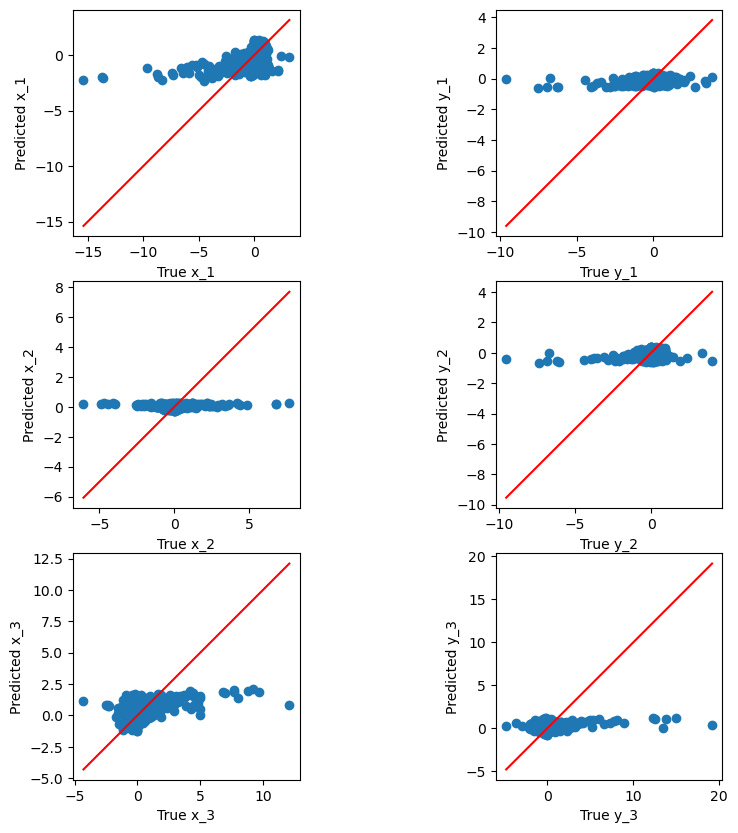

In [32]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy())

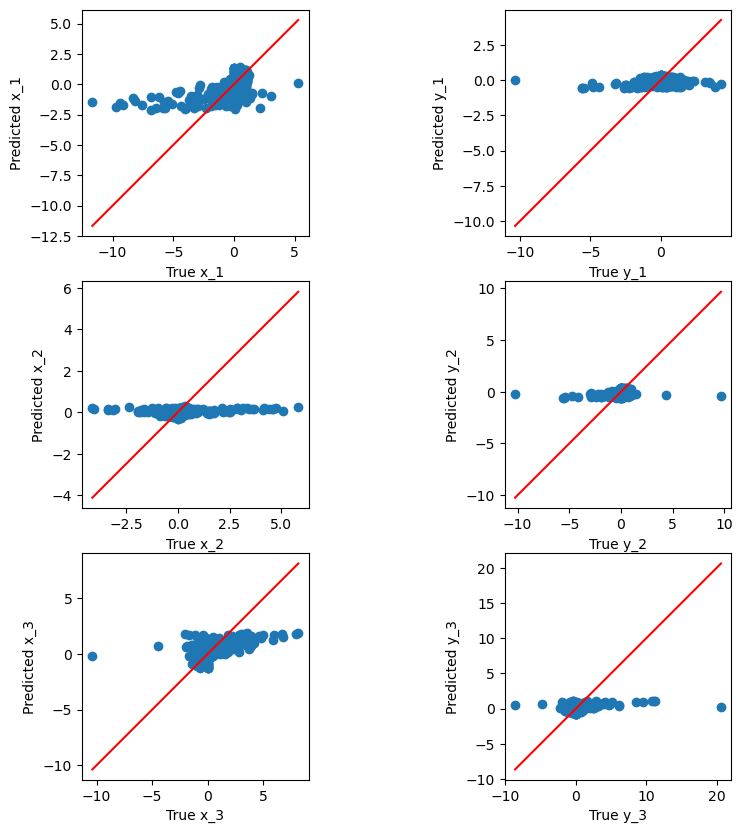

In [33]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy())

## Polynomial Regression - tryouts :) - skip

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [24]:
pipe2= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=3)),
            ('model', Ridge())
    ])

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV

kfold2 = GroupKFold(n_splits=10)

pipe2= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=2)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

for fold_num, (train_index, validation_index) in enumerate(kfold2.split(input_train, output_train, groups=groups)):
    # Indexing with iloc
    X_train, X_validation = input_train.iloc[train_index], input_train.iloc[validation_index]
    y_train, y_validation = output_train.iloc[train_index], output_train.iloc[validation_index]


    pipe2.fit(X_train, y_train)

    n_features = pipe2.named_steps['preprocessor'].n_output_features_
    print(n_features)

    y_train_predict = pipe2.predict(X_train)
    y_val_predict = pipe2.predict(X_validation)


    train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
    print("Train MSE:", train_error)

    val_error = np.sqrt(mean_squared_error(y_validation, y_val_predict))
    print("Test MSE:", val_error)

36
Train MSE: 1.2820828974967307
Test MSE: 1.1146594490665405
36
Train MSE: 1.2704791719735837
Test MSE: 1.2282693446991575
36
Train MSE: 1.2649694794777906
Test MSE: 1.27836050958485
36
Train MSE: 1.2698781891455089
Test MSE: 1.2339978785451793
36
Train MSE: 1.2755660868278926
Test MSE: 1.1796863960496657
36
Train MSE: 1.252916288458003
Test MSE: 1.3813179070995474
36
Train MSE: 1.2253204370646649
Test MSE: 1.5892469182274234


KeyboardInterrupt: 

In [ ]:
kfold3 = GroupKFold(n_splits=10)

pipe3= Pipeline(
        [       ('preprocessor', PolynomialFeatures(degree=3)),
                ('model', Ridge())
        ])

for fold_num, (train_index, validation_index) in enumerate(kfold3.split(input_train, output_train, groups=groups)):
    # Indexing with iloc
    X_train, X_validation = input_train.iloc[train_index], input_train.iloc[validation_index]
    y_train, y_validation = output_train.iloc[train_index], output_train.iloc[validation_index]


    pipe3.fit(X_train, y_train)

    n_features = pipe3.named_steps['preprocessor'].n_output_features_
    print(n_features)

    y_train_predict = pipe3.predict(X_train)
    y_val_predict = pipe3.predict(X_validation)


    train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
    print("Train MSE:", train_error)

    val_error = np.sqrt(mean_squared_error(y_validation, y_val_predict))
    print("Test MSE:", val_error)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    
    best_rsme = 1000
    best_degree = 0
    train_scores = []
    validation_scores = []
    n_features_list = []

    for d in degrees:

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)

        #print("Degree:", d) 

        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
        #print("Train MSE:", train_error)

        val_error = np.sqrt(mean_squared_error(y_val, y_val_predict))
        #print("Test MSE:", test_error)

        if val_error < best_rsme:
            best_rsme = val_error
            best_degree = d

        train_scores.append(train_error)
        validation_scores.append(val_error)
    
    return train_scores, validation_scores, best_rsme, best_degree, n_features_list

In [ ]:
from sklearn.model_selection import train_test_split

kfold = GroupKFold(n_splits=5)

degrees=range(1,15)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

input_train=input_train[0:6425]
output_train=output_train[0:6425]
groups=groups[0:6425]


for fold_num, (train_index, validation_index) in enumerate(kfold.split(input_train, output_train, groups=groups)):
    # Indexing with iloc
    X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

    # Validate polynomial regression for each fold
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(X_train, y_train, X_validation, y_validation)
    
    best_rsmes.append(best_rsme)
    best_degrees.append(best_degree)

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])


In [ ]:
print("Best RSME: ", best_rsmes, 
        "\nBest degree: ", best_degrees, 
        "\nDegree scores: ", degree_scores, 
        "\nFeatures outputed" , n_features_list)

## Polynomial regression - real

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,10), max_features=None):
    
    best_rsme = 1000
    best_degree = 0
    train_scores = []
    validation_scores = []
    n_features_list = []

    for d in degrees:
        print("Degree ", d)

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)

        #print("Degree:", d) 

        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
        #print("Train MSE:", train_error)

        val_error = np.sqrt(mean_squared_error(y_val, y_val_predict))
        #print("Test MSE:", test_error)

        if val_error < best_rsme:
            best_rsme = val_error
            best_degree = d

        train_scores.append(train_error)
        validation_scores.append(val_error)

        print("Val error: ", val_error)

    return train_scores, validation_scores, best_rsme, best_degree, n_features_list

In [40]:
#input_train=input_train[0:6425]
#output_train=output_train[0:6425]
#groups=groups[0:6425]


sample_train_set = train_set.sample(frac=0.01)
sample_input_train = sample_train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
sample_output_train = sample_train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]

In [ ]:
degrees=range(1,10)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

for _ in range(10):
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(sample_input_train, sample_output_train, input_validation, output_validation)

    best_rsmes.append(best_rsme)
    best_degrees.append(best_degree)

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])


Degree  1
Val error:  1.4107589292391254
Degree  2
Val error:  1.3851899557452574
Degree  3
Val error:  1.3520072610931078
Degree  4
Val error:  1.3139179788801452
Degree  5
Val error:  9.770098211902752
Degree  6
Val error:  120682.18673809215
Degree  7


## Train all data on the best degree polynomial model

In [ ]:
best_degree_ever = max(set(best_degrees), key=best_degrees.count)

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
    ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)

train_error = np.sqrt(mean_squared_error(output_train, output_train_predict))
print("Train MSE:", train_error)

val_error = np.sqrt(mean_squared_error(output_validation, output_val_predict))
print("Validation MSE:", train_error)